In [1]:
#Import libraries#

import cv2
import scipy.misc as sm
import numpy as np
from matplotlib import pyplot as plt


In [32]:

#Reading ref_image and dataset, setting list index#
img1 = cv2.imread('ficarra1.jpg')
vettore_immagini_lette=[cv2.imread('ficarra1.jpg'),cv2.imread('sosia_1.jpg'),cv2.imread('sosia_2.jpg'),cv2.imread('sosia_3.jpg'),cv2.imread('marcelo.jpg'),cv2.imread('obama1.jpg'),cv2.imread('index.jpeg')] 
indicelista=0


In [33]:

#Convert color to gray scale
imgquery=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
immaginicolor=[]
for i in range(0,len(vettore_immagini_lette)):
    immaginicolor.append(cv2.cvtColor(vettore_immagini_lette[i],cv2.COLOR_BGR2GRAY))


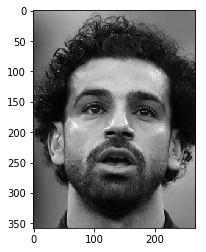

In [34]:

#Plot dataset#
plt.imshow(immaginicolor[1],cmap='gray')


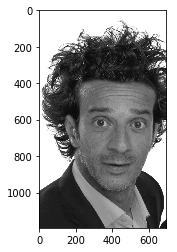

In [35]:

#Plot ref_image#
plt.imshow(imgquery,cmap="gray")


In [36]:

#Create new function with a detector and matcher return#
def init_feature(name): 

    detector = None
    norm = None
    matcher = None

    FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
    FLANN_INDEX_LSH = 6
    chunks = name.split('-')
    if chunks[0] == 'sift':
        detector = cv2.xfeatures2d.SIFT_create()
        norm = cv2.NORM_L2
    elif chunks[0] == 'surf':
        detector = cv2.xfeatures2d.SURF_create(800)
        norm = cv2.NORM_L2
    elif chunks[0] == 'orb':
        detector = cv2.ORB_create(400)
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'akaze':
        detector = cv2.AKAZE_create()
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'brisk':
        detector = cv2.BRISK_create()
        norm = cv2.NORM_HAMMING
    else:
        return None, None


    if 'flann' in chunks:
        if norm == cv2.NORM_L2:
            flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        else:
            flann_params = dict(algorithm=FLANN_INDEX_LSH,
                                table_number=6,  # 12
                                key_size=12,  # 20
                                multi_probe_level=1)  # 2
        matcher = cv2.FlannBasedMatcher(flann_params, {})  # bug : need to pass empty dict (#1329)
    else:
        matcher = cv2.BFMatcher(norm)
    return detector, matcher


In [37]:

#Select algorithm#
detector_matcher = 'akaze-flann'
#detector_matcher = 'orb-flann'
#detector_matcher = 'akaze-flann'
#detector_matcher = 'brisk-flann'


In [38]:

#Create new variable matcher and detector and use init_features function#
detector,matcher = init_feature(detector_matcher)


In [39]:

kp1, desc1 = detector.detectAndCompute(imgquery, None)
kp2, desc2 = detector.detectAndCompute(immaginicolor[indicelista], None)


In [40]:

img1_annotated = np.zeros_like(imgquery)
img2_annotated = np.zeros_like(immaginicolor[indicelista])


In [41]:

img1_annotated = cv2.drawKeypoints(imgquery,kp1,img1_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_annotated = cv2.drawKeypoints(immaginicolor[indicelista],kp2,img2_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


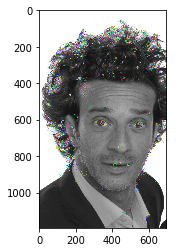

In [42]:

plt.imshow(img1_annotated)


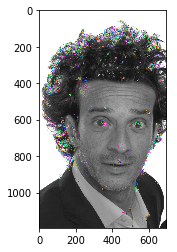

In [43]:

plt.imshow(img2_annotated)


In [44]:

#Calculate good matches#
raw_matches = matcher.knnMatch(desc1, trainDescriptors=desc2, k=2)


In [45]:

#Return number of elements for raw_matches variable#
np.size(raw_matches)


3584

In [46]:

#Create new function with p1 p1 kp_pairs return#
def filter_matches(kp1, kp2, matches, ratio=0.75):

    mkp1, mkp2 = [], []


    m = []

    for m in matches:

        if len(m) == 2 and m[0].distance < m[1].distance * ratio:

            m = m[0]
            mkp1.append(kp1[m.queryIdx])
            mkp2.append(kp2[m.trainIdx])


    #if debug_mode:print("appended keypoints")
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    return p1, p2, kp_pairs


In [47]:

#Set up new variables from filter_matches function# 
q, a, kp_pairs = filter_matches(kp1, kp2, raw_matches)


In [48]:

np.shape(kp_pairs)


(1792, 2)

In [49]:

#Set up new variables from imported homography function# 
H, status = cv2.findHomography(q,a,cv2.RANSAC,5.0)


In [50]:

imgquery.shape


(1194, 698)

In [51]:
immaginicolor[indicelista].shape

(1194, 698)

In [52]:

h1, w1  = imgquery.shape[:2]
h2, w2  = immaginicolor[indicelista].shape[:2]
vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)


In [53]:

vis[:h1, :w1] = immaginicolor[indicelista]


In [54]:

vis[:h2, w1:w1 + w2] = immaginicolor[indicelista]


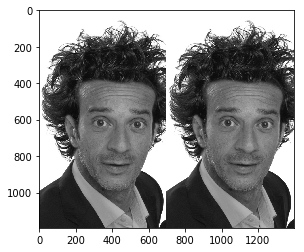

In [55]:

plt.imshow(vis,cmap="gray")


In [56]:

vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)


In [57]:

#Set up red and green grid#
green = (0, 255, 0)
red = (0, 0, 255)


In [58]:

p1 = np.int32([kpp[0].pt for kpp in kp_pairs])
p2 = np.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)


In [59]:

corners_starting = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
corners_ending = np.int32(cv2.perspectiveTransform(corners_starting.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0))
vis = cv2.polylines(vis, [corners_ending], True, (255, 0, 0),12)


In [60]:

for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
    if inlier:
        cv2.line(vis, (x1, y1), (x2, y2), green)
        

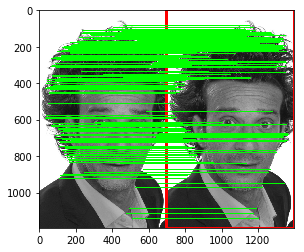

In [61]:

#Plot vis run#
plt.imshow(vis)
